In [1]:
from os import listdir
from os import path
from random import sample
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def loadDat(filename):
  fh = open(filename)
  dat = pd.read_csv(fh)
  fh.close()
  return dat

In [2]:
year = 2023
datadir = path.join('.', str(year))
files = listdir(datadir)
files

['proj_k23.csv',
 'proj_qb23.csv',
 'proj_rb23.csv',
 'proj_te23.csv',
 'proj_wr23.csv']

In [3]:
# need to exclude "current" data
files = [i for i in files if 'proj' in i]
patt = r'proj_(.*)' + str(year)[2:4] + '.csv'
pos = [re.sub(patt, r'\1', f) for f in files]
dat = {}
cols = set()
for p in pos:
  dat[p] = loadDat(path.join(datadir, files[pos.index(p)]))
  cols.update(set(dat[p].columns))
for p in pos:
  nr = len(dat[p].index)
  nodat = [0 for i in range(nr)]
  for i in cols.difference(set(dat[p].columns)):
    dat[p][i] = nodat
  dat[p] = dat[p][list(cols)]
  dat[p]['pos'] = [p for i in range(nr)]
col1 = ['PlayerName','Team','pos','fpts']
colo = col1 + list(cols.difference(col1))
m = pd.concat(dat)[colo]
m['p_fg'] = m['fg'] * 4
m['p_xpt'] = m['xpt'] * 1
m['p_pass_yds'] = m['pass_yds'] / 25
m['p_pass_tds'] = m['pass_tds'] * 4
m['p_pass_ints'] = m['pass_ints'] * -2
m['p_rush_yds'] = m['rush_yds'] / 10
m['p_rush_tds'] = m['rush_tds'] * 6
m['p_fumbles'] = m['fumbles'] * -2
m['p_rec_yds'] = m['rec_yds'] / 20
m['p_rec_tds'] = m['rec_tds'] * 6
m['points'] = m.filter(regex = ("p_.*")).sum(axis = 1)
m = m.sort_values(by=['points'], ascending = False)
basePnt = {}
basePnt['k'] = m.loc[('k'),'points'].iloc[11]
basePnt['qb'] = m.loc[('qb'),'points'].iloc[11]
basePnt['rb'] = m.loc[('rb'),'points'].iloc[12*2-1]
basePnt['te'] = m.loc[('te'),'points'].iloc[11]
basePnt['wr'] = m.loc[('wr'),'points'].iloc[12*3-1]
m['marg'] = m['points'] - [basePnt[i] for i in m['pos']]
# alternative
#m.loc['qb','marg'] = (m.loc['qb','points'] - m.loc[('qb',12),'points']).values
d1 = m.loc[m['marg'] >= 0, ['PlayerName','pos','points','marg']]
d2 = d1.sort_values(by=['marg'], ascending = False)
d2['value'] = (12 * 200 - len(d2)) * d2['marg'] / sum(d2['marg']) + 1
d3 = d2.reset_index(drop = True)

In [4]:
d3.head()

,PlayerName,pos,points,marg,value
0,Patrick Mahomes II,qb,372.744,85.822,95.903171
1,Jalen Hurts,qb,367.774,80.852,90.407275
2,Josh Allen,qb,366.710,79.788,89.230689
3,Travis Kelce,te,119.710,66.550,74.591923
4,Nick Chubb,rb,204.445,61.125,68.592882


In [5]:
d3.tail()

,PlayerName,pos,points,marg,value
91,Jahmyr Gibbs,rb,143.320,0.0,1.0
92,Kadarius Toney,wr,72.900,0.0,1.0
93,Daniel Jones,qb,286.922,0.0,1.0
94,Brandon McManus,k,146.700,0.0,1.0
95,Dalton Schultz,te,53.160,0.0,1.0


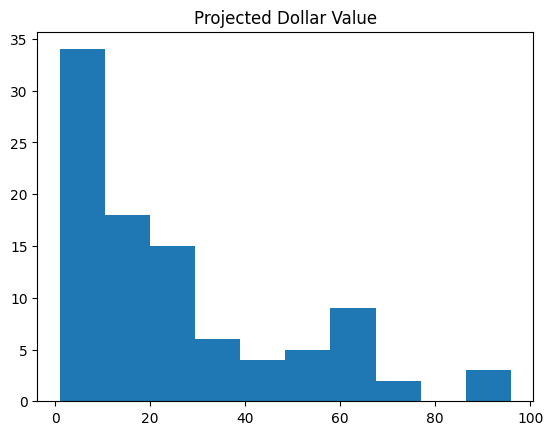

In [6]:
plt.hist(np.hstack(d3['value']))
plt.title('Projected Dollar Value')
plt.show()

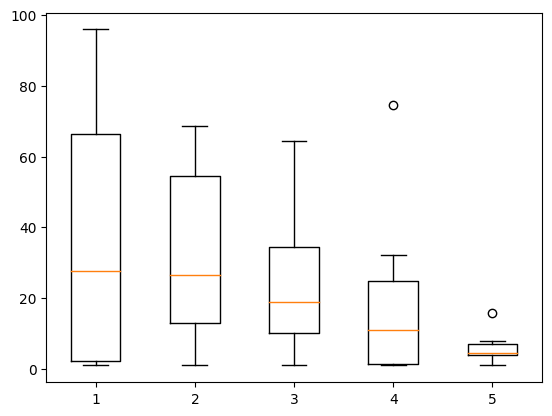

In [7]:
fig1, ax1 = plt.subplots()
data = [d3.loc[d3['pos'] == 'qb','value'], d3.loc[d3['pos'] == 'rb','value'], d3.loc[d3['pos'] == 'wr','value'], d3.loc[d3['pos'] == 'te','value'], d3.loc[d3['pos'] == 'k','value']]
ax1.boxplot(data)
plt.show()

In [8]:
# select rows by index
d3.iloc[range(0,3)]

,PlayerName,pos,points,marg,value
0,Patrick Mahomes II,qb,372.744,85.822,95.903171
1,Jalen Hurts,qb,367.774,80.852,90.407275
2,Josh Allen,qb,366.710,79.788,89.230689


In [9]:
# select rows by name
d3.loc[[10,20,40,80]]

,PlayerName,pos,points,marg,value
10,Justin Jefferson,wr,127.275,54.375,61.128637
20,Stefon Diggs,wr,114.480,41.580,46.979747
40,Garrett Wilson,wr,92.135,19.235,22.270333
80,Harrison Butker,k,149.100,2.400,3.653954


In [10]:
# select columns by index, and first 10 rows
d3.iloc[range(10),[0,4]]

,PlayerName,value
0,Patrick Mahomes II,95.903171
1,Jalen Hurts,90.407275
2,Josh Allen,89.230689
3,Travis Kelce,74.591923
4,Nick Chubb,68.592882
5,Derrick Henry,67.116620
6,Ja'Marr Chase,64.495841
7,Cooper Kupp,64.263620
8,Christian McCaffrey,64.075632
9,Josh Jacobs,61.156283


In [11]:
# select columns by name, and 5 random rows
d3.iloc[sample(range(len(d3)), 5), [d3.columns.get_loc(i) for i in ['pos','value']]]

,pos,value
43,rb,20.982059
35,rb,24.979577
86,qb,1.917826
36,te,24.868996
66,rb,7.308669


In [12]:
# be careful when selecting a single column
# no longer a DataFrame
d3.iloc[range(5), d3.columns.get_loc('PlayerName')]

0    Patrick Mahomes II
1           Jalen Hurts
2            Josh Allen
3          Travis Kelce
4            Nick Chubb
Name: PlayerName, dtype: object

In [13]:
# maintain structure
pd.DataFrame(d3.iloc[range(5), d3.columns.get_loc('PlayerName')])

,PlayerName
0,Patrick Mahomes II
1,Jalen Hurts
2,Josh Allen
3,Travis Kelce
4,Nick Chubb


In [14]:
# select rows that satisfy condition
# every 10th row
d3.loc[[(i + 1) % 10 == 0 for i in range(len(d3))]]

,PlayerName,pos,points,marg,value
9,Josh Jacobs,rb,197.720,54.400,61.156283
19,Saquon Barkley,rb,186.190,42.870,48.406247
29,Najee Harris,rb,168.145,24.825,28.451833
39,Tee Higgins,wr,92.715,19.815,22.911705
49,Zane Gonzalez,k,160.200,13.500,15.928489
59,DeAndre Hopkins,wr,82.045,9.145,11.112669
69,Justin Tucker,k,152.100,5.400,6.971396
79,Chris Godwin,wr,75.520,2.620,3.897233
89,Dak Prescott,qb,287.104,0.182,1.201258


In [15]:
# quarterbacks
d3.loc[d3['pos'] == 'qb']

,PlayerName,pos,points,marg,value
0,Patrick Mahomes II,qb,372.744,85.822,95.903171
1,Jalen Hurts,qb,367.774,80.852,90.407275
2,Josh Allen,qb,366.710,79.788,89.230689
13,Lamar Jackson,qb,339.086,52.164,58.683682
17,Joe Burrow,qb,333.118,46.196,52.084184
28,Justin Fields,qb,313.156,26.234,30.009925
34,Justin Herbert,qb,308.838,21.916,25.235020
48,Deshaun Watson,qb,300.980,14.058,16.545533
84,Trevor Lawrence,qb,288.248,1.326,2.466309
86,Kirk Cousins,qb,287.752,0.830,1.917826


In [16]:
# wide receivers or tight ends, but only first 10
d3.loc[[i in ['wr','te'] for i in d3['pos']]].iloc[range(10)]

,PlayerName,pos,points,marg,value
3,Travis Kelce,te,119.710,66.550,74.591923
6,Ja'Marr Chase,wr,130.320,57.420,64.495841
7,Cooper Kupp,wr,130.110,57.210,64.263620
10,Justin Jefferson,wr,127.275,54.375,61.128637
12,Tyreek Hill,wr,125.235,52.335,58.872777
18,CeeDee Lamb,wr,118.500,45.600,51.425119
20,Stefon Diggs,wr,114.480,41.580,46.979747
21,Davante Adams,wr,114.120,41.220,46.581654
22,A.J. Brown,wr,111.920,39.020,44.148863
23,Deebo Samuel,wr,106.135,33.235,37.751729


In [17]:
# same thing, different way
d3.loc[[re.match(r'wr|te', i) is not None for i in d3['pos']]].iloc[range(10)]

,PlayerName,pos,points,marg,value
3,Travis Kelce,te,119.710,66.550,74.591923
6,Ja'Marr Chase,wr,130.320,57.420,64.495841
7,Cooper Kupp,wr,130.110,57.210,64.263620
10,Justin Jefferson,wr,127.275,54.375,61.128637
12,Tyreek Hill,wr,125.235,52.335,58.872777
18,CeeDee Lamb,wr,118.500,45.600,51.425119
20,Stefon Diggs,wr,114.480,41.580,46.979747
21,Davante Adams,wr,114.120,41.220,46.581654
22,A.J. Brown,wr,111.920,39.020,44.148863
23,Deebo Samuel,wr,106.135,33.235,37.751729


In [18]:
# values greater than 45
d3.loc[d3['value'] > 45]

,PlayerName,pos,points,marg,value
0,Patrick Mahomes II,qb,372.744,85.822,95.903171
1,Jalen Hurts,qb,367.774,80.852,90.407275
2,Josh Allen,qb,366.710,79.788,89.230689
3,Travis Kelce,te,119.710,66.550,74.591923
4,Nick Chubb,rb,204.445,61.125,68.592882
5,Derrick Henry,rb,203.110,59.790,67.116620
6,Ja'Marr Chase,wr,130.320,57.420,64.495841
7,Cooper Kupp,wr,130.110,57.210,64.263620
8,Christian McCaffrey,rb,200.360,57.040,64.075632
9,Josh Jacobs,rb,197.720,54.400,61.156283


In [19]:
# combining conditions with AND
# running backs with value between 10 and 15
d3.loc[(d3['pos'] == 'rb') & (d3['value'] >= 20) & (d3['value'] <= 25)]

,PlayerName,pos,points,marg,value
35,Aaron Jones,rb,165.005,21.685,24.979577
38,Kenneth Walker III,rb,164.735,21.415,24.681007
41,Travis Etienne Jr.,rb,161.985,18.665,21.640019
43,Alexander Mattison,rb,161.390,18.070,20.982059


In [20]:
# combining conditions with OR
# rounded value ends in '9' or value is 1
d3.loc[(round(d3['value']) % 10 == 9) | (d3['value'] == 1)]

,PlayerName,pos,points,marg,value
2,Josh Allen,qb,366.710,79.788,89.230689
4,Nick Chubb,rb,204.445,61.125,68.592882
11,Bijan Robinson,rb,195.980,52.660,59.232166
12,Tyreek Hill,wr,125.235,52.335,58.872777
13,Lamar Jackson,qb,339.086,52.164,58.683682
44,Calvin Ridley,wr,89.530,16.630,19.389687
45,DeVonta Smith,wr,89.525,16.625,19.384158
91,Jahmyr Gibbs,rb,143.320,0.000,1.000000
92,Kadarius Toney,wr,72.900,0.000,1.000000
93,Daniel Jones,qb,286.922,0.000,1.000000


In [21]:
# combining conditions with complicated combinations
# kickers with value > 6 or tight end with value < 5
d3.loc[((d3['pos'] == 'k') & (d3['value'] > 6)) | ((d3['pos'] == 'te') & (d3['value'] < 5))]

,PlayerName,pos,points,marg,value
49,Zane Gonzalez,k,160.200,13.500,15.928489
62,Greg Joseph,k,152.900,6.200,7.856047
65,Jason Myers,k,152.500,5.800,7.413721
69,Justin Tucker,k,152.100,5.400,6.971396
71,Daniel Carlson,k,151.500,4.800,6.307907
82,Pat Freiermuth,te,55.500,2.340,3.587605
87,Greg Dulcich,te,53.465,0.305,1.337273
88,David Njoku,te,53.350,0.190,1.210105
90,Evan Engram,te,53.220,0.060,1.066349
95,Dalton Schultz,te,53.160,0.000,1.000000


In [22]:
# select columns that match pattern
m.filter(regex = ("p_.*")).iloc[range(10)]

p_fg  p_xpt  p_pass_yds  p_pass_tds  p_pass_ints  p_rush_yds  \
qb 0    0.0    0.0     193.264       150.8        -22.4       35.68   
   2    0.0    0.0     152.884        94.8        -20.2       80.09   
   1    0.0    0.0     171.160       128.4        -28.4       66.15   
   3    0.0    0.0     139.196       102.0        -23.2       94.09   
   4    0.0    0.0     183.608       130.8        -25.8       26.91   
   5    0.0    0.0     116.516        80.8        -25.6      107.04   
   6    0.0    0.0     183.768       120.4        -25.4       22.07   
   7    0.0    0.0     155.000        98.8        -22.0       48.18   
   9    0.0    0.0     163.508       107.6        -24.4       28.54   
   10   0.0    0.0     177.752       122.0        -24.6        9.20   

       p_rush_tds  p_fumbles  p_rec_yds  p_rec_tds  
qb 0         19.2       -3.8        0.0        0.0  
   2         66.0       -5.8        0.0        0.0  
   1         37.8       -8.4        0.0        0.0  
   3         33.0       -6.0        0.0        0.0  
   4         22.2       -4.6        0.0        0.0  
   5         41.4       -7.0        0.0        0.0  
   6         12.0       -4.0        0.0        0.0  
   7         24.6       -3.6        0.0        0.0  
   9         23.4      -10.4        0.0        0.0  
   10         9.0       -5.6        0.0        0.0

In [23]:
# select empty DataFrame
d3.loc[[False] * len(d3)]

,PlayerName,pos,points,marg,value


<!--
quarto render ffv_py.qmd
-->